# Astronomy 8824 - Numerical and Statistical Methods in Astrophysics

## Introduction to Density Estimation

These notes are for the course Astronomy 8824: Numerical and Statistical Methods in Astrophysics and were written by Paul Martini. 

In [1]:
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import astropy
import sys, os
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.mixture import GaussianMixture

import urllib
from astropy.io import fits

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

### Density Estimation

Density estimation is the use of point data to estimate the probability density distribution, and it is a form of data smoothing.

A very simple form of density estimation is a histogram. This is valuable for data exploration, but not a good idea for statistical analysis. Some problems with histograms include variations due to the bin sizes and locations, and that the discontinuities between bins may not reflect the true distribution of the population. 

It is advantageous, and often necessary, to estimate the density distribution nonparametrically, that is without the use of a model that presupposes the distribution can be described by a parameterized model, or even the bin sizes and locations of a histogram. This is because the use of a model can bias the analysis in a particular direction and obscure potentially important features. And a nonparametric analysis may be necessary if one has no particular model already. Non-parametric density estimation is a fundamental tool in data exploration.

Parametric density estimation is valuable if one knows (or suspects) that the data will match some known pdf. This is because one can generally specify or describe the pdf with a relatively small number number of parameters compared to the non-parametric approach. 

### Kernel Density Estimation

(Reference: Ivezic et al. $\S6.1$) 

The appearance of a one-dimensional histogram can be sensitive to the location of bin edges and bin sizes, and such differences can impact the interpretation of the data. 

In a histogram, each point contributes one unit to the height of its bin. In KDE, each point has its own bin of unit height and some fixed width. The distribution is then the sum of all of these boxes. The unit bin for each point is called the kernel, and in this case the rectangular box is called a tophat kernel, and the width is a fixed parameter called the bandwidth. 

A fixed bandwidth is already a better way to estimate the density than a histogram, although it does not produce a smooth (differentiable) distribution, and may have unsightly features such as spikes in the distribution. For these reasons, many other kernels are used, such as a Gaussian, Epanechnikov, exponential, triangle, etc. 

The Epanechnikov kernel is:

$$
K(x) = \frac{3}{4} (1 - x^2)
$$
for $|x| \leq 1$ and zero otherwise. This has been claimed to be the theoretically optimal kernal in terms of the minimum variance. 

For $N$ data points $x_i$ that are drawn from a distribution $p(x)$, the kernel density estimate of $p(x)$ is

$$
\hat{p}_h(x) = \frac{1}{N h} \sum^N_{i=1} K \left( \frac{x - x_i}{h} \right)
$$

where $K$ is the kernel function and $h$ is the bandwidth. The estimate $\hat{p}_h(x)$ provides the density estimate at each point $x$ based on the sum of the contributions of each point $x_i$, where these contributions are distributed over a range of $x$ by the kernel, and not to a single value at $x_i$. 

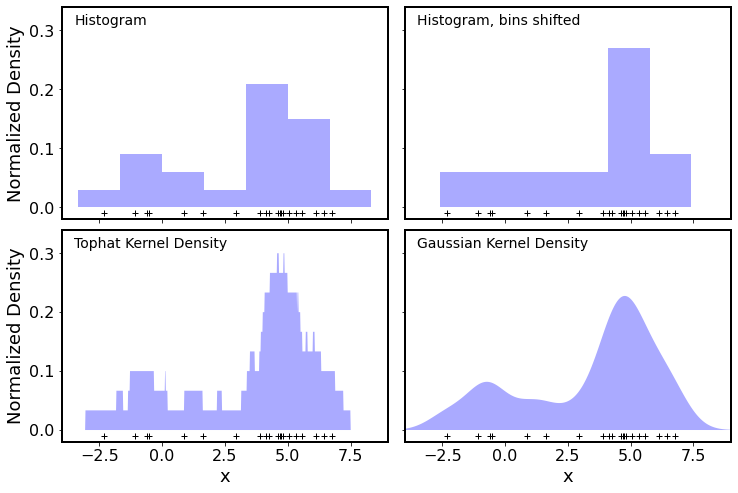

In [2]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
#
# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')

Say something about available kernels, operation of Kernel Density Estimator in scikit-learn

Text(0.5, 1.0, 'Available Kernels')

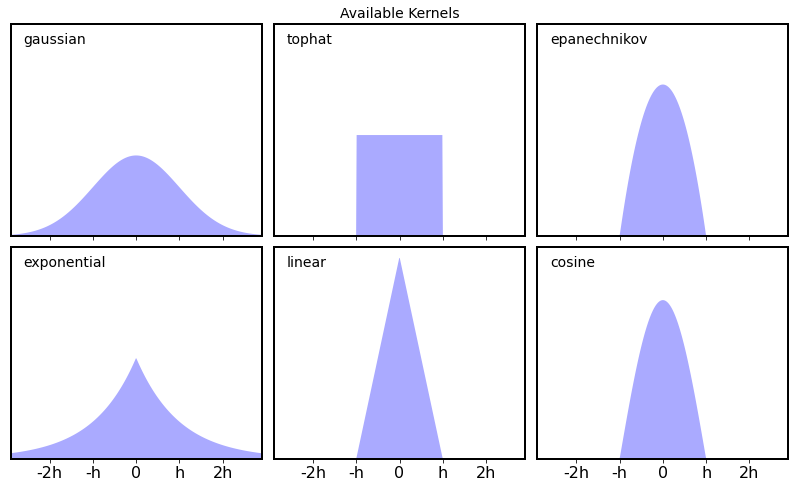

In [3]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
#
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x


for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')

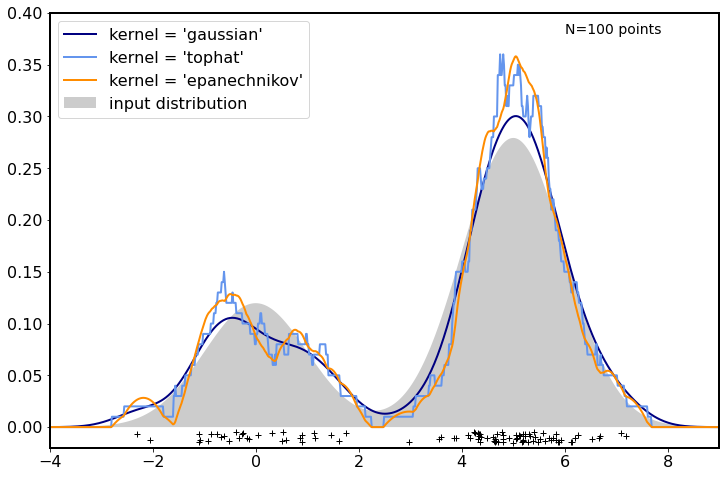

In [4]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
#
# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots(figsize=(12,8))
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

While KDE is called a non-parametric density estimation method, the width of the kernel is a parameter. The kernel is also a parameter, although the estimate of the pdf is less sensitive to the choice of kernel than the choice of width. In the limit of zero width, the estimate reduces to the point data, and if the width is too large, this could hide important features in the data. 

Two methods to estimate the width are cross-validation and the mean integrated square error. 

#### Cross Validation

Cross validation is a method that uses one subset of the data to train a model and another subset to test or validate the model. The goal is to test the performance of a given model with data that were not used to construct the model. This can occur with a single division of the data into a training and a testing set, although it is more common (and generally more powerful) to use multiple iterations of random training and testing subsets and then combine the results of these iterations.  

Cross validation methods are commonly split into exhaustive and non-exhaustive methods. Exhaustive methods calculate every possible division of the original sample, and non-exhaustive ones do not. For large datasets, non-exhaustive methods are more commonly used as they are more computationally tractable. 

Exhaustive methods can be generalized as 'leave-k-out cross validation,' where k is the number of observations in the validation set that are 'left out' of the training set. For $n$ data points, the number of iterations is the binomial coefficient: 
$$
C^n_k = \binom{n}{k} = \frac{n!}{k! (n-k)!}
$$
This quickly becomes very large for even moderate sample sizes. 

A simple version of this is to set $k = 1$. This is similar to jackknife resampling, except the cross validation is computed with the sample that is left out (validation sample) and not the samples with $n-1$ elements. In this case the cross validation is:
$$
CV_l (h) = \frac{1}{N} \sum^N_{i=1} \log \hat{f}_{h,-i}(x_i)
$$
and $\hat{f}_{h,-i}(x_i)$ is the KDE for the sample without element $i$. One can then solve for $h$ by minimizing $CV_l(h)$. 

#### Mean Integrated Square Error

The Mean Integrated Square Error (MISE) is a risk or cost function that ascribes some cost to an event, and thereby provides a way to compare different outcomes. The MISE for some bandwidth $h$ is equal to the expectation value of the integral:

$$
\mathrm{MISE} (h) = \langle \int \left( \hat{f}_h(x) - f(x) \right)^2 dx \rangle
$$

where $\hat{f}_h(x)$ is the KDE for bandwidth $h$. 

### Parametric Density Estimate with Gaussian Mixture Models

(Reference Ivezic et al., $\S\S 4.4, 6.3$) 

Parametric density estimation adopts some parametrized model (e.g. a Gaussian) and fits some number of these to the point data to describe the probability density distribution, yet does not assign any one point to any one of the models. This type of model is called a mixture model. The mixture part is that the point data are represented by a mixture of various models without assigning the data to any one model. 

A Gaussian Mixture Model is when a Gaussian is adopted for the mixture model. 

#### One-dimensional case

Consider the case of $N$ observations of data points $x_i$ where one would like to fit $K$ components. Each of these components has two parameters ($\mu_k, \sigma_k$) and a weight $\phi_k$ that defines the contribution of each Gaussian where 
$$
\sum^K_{k=1} \phi_k = 1
$$

and the likelihood for a data point $x_i$ is:
$$
p(x_i | \vec \theta) = \sum^{K}_{k=1} \phi_k \mathcal{N} (\mu_k, \sigma_k)
$$

where $\vec \theta$ has all of the parameters ($\mu, \sigma, \phi$) for each of the $K$ Gaussians. 

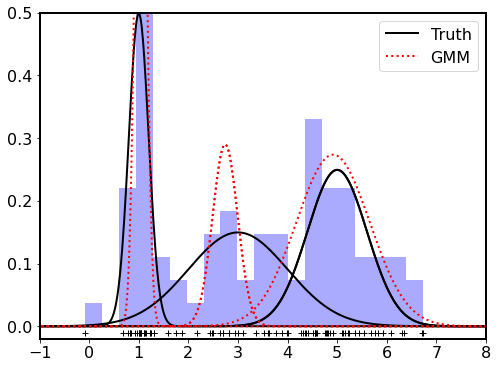

In [5]:
# Generate a dataset from three Gaussian distributions
np.random.seed(1216)
plt.figure(figsize=(8,6))
mu = [1, 3, 5]
sig = [.2, 1, .6]
num = [20, 30, 30]
phi = np.asarray(num)/sum(num)
x = []
y = np.linspace(-2, 10, 1000)
for i in range(len(mu)): 
    x.append( np.random.normal(mu[i], sig[i], size=num[i]))
    plt.plot(y, phi[i]*norm.pdf(y, mu[i], sig[i]), 'k-')
    
plt.plot(y, phi[i]*norm.pdf(y, mu[i], sig[i]), 'k-', label="Truth")
x = np.hstack(x)

plt.hist(x, bins=20, fc='#AAAAFF', **density_param)
plt.plot(x, np.full(x.shape[0], -0.01), '+k')
plt.xlim(-1, 8)
plt.ylim(-0.02, 0.5)

x = x.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=0).fit(x)
log_dens = gmm.score(x)

# Plot the GMM results
for i in range(len(mu)):
    plt.plot(y, gmm.weights_[i]*norm.pdf(y, gmm.means_[i][0], gmm.covariances_[i][0][0]), 'r:')
    
plt.plot(y, gmm.weights_[i]*norm.pdf(y, gmm.means_[i][0], gmm.covariances_[i][0][0]), 'r:', label="GMM")

plt.legend()

It is generally not possible to solve for the model parameters with a straightforward, maximum likelihood approach. The log likelihood for an entire dataset of $N$ points is:

$$
\ln L = \sum^{N}_{i=1} \left( \sum^{K}_{k=1} \phi_k \mathcal{N}(\mu_k, \sigma_k) \right)
$$

and there are $3K - 1$ parameters. Taking partial derivatives with respect to all of these parameters would result in a system of as many equations. This is distinct from a single Gaussian, as in this case one needs to sum over $K$ models. 

The common procedure to solve for the likelihood is to instead use a concept known as _hidden variables_. The basic idea is to start with an initial trial where each point is assigned to one of the $K$ Gaussians. We then use all of the points assigned to each of the $K$ Gaussians to solve for the model parameters of each Gaussian separately and one can then trivially solve for the model parameters of each Gaussian. One can then use this model to calculate the probability that a given point $x_i$ was actually generated by model $k$:

$$
p(k|x_i) = \frac{ \phi_k \mathcal{N} (\mu_k, \sigma_k) }{\sum^{K}_{k=1} \phi_k \mathcal{N} (\mu_k, \sigma_k) }
$$

The standard way to compute the likelihood with this approach is called Expectation Maximization. The key assumption is $p(k|x_i)$ is known and fixed for each iteration. The partial derivative of the log likelihood is:

$$
\frac{ \partial \ln L}{\partial \theta_k} = \sum^{N}_{i=1} 
\left( \frac{\phi_k p_k (x_i | \vec \theta)}{\sum^K_{k=1} \phi_k p_k(x_i|\vec \theta)} \right)
\left( \frac{1}{p_k (x_i | \vec \theta)} \frac{\partial p_k (x_i | \vec \theta)}{\partial \theta_k } \right)
$$

where $p_k(x_i|\vec \theta)$ allows for a more general mixture model than $\mathcal{N}$. The first term in parenthesis is fixed with each iteration and so is a constant, and the second term is the partial derivative of $\ln p_k(x_i|\vec \theta)$. If the pdf is a Gaussian, this equation simplifies to: 

$$
\frac{ \partial \ln L}{\partial \theta_k} = - \sum^{N}_{i=1} w_{ik} \frac{\partial}{\partial \theta_k} \left( \ln \sigma_k + \frac{(x_i - \mu_k)^2}{2 \sigma_k^2} \right) 
$$

where the first term has been replaced with $w_{ik}$ and for a Gaussian the partial derivatives with respect to $\theta_k$ are ($\mu_k, \sigma_k$) are:

$$
\mu_k = \frac{\sum^{N}_{i=1} w_{ik} x_i}{\sum^{N}_{i=1} w_{ik} }
$$

$$
\sigma_k^2 = \frac{\sum^{N}_{i=1} w_{ik} (x_i - \mu_k)^2}{\sum^{N}_{i=1} w_{ik} }
$$

and 
$$
\phi_k = \frac{1}{N} \sum^N_{i=1} w_{ik}
$$

The procedure is to start with a guess for the $w_{ik}$, estimate the parameters by maximizing the likelihood, and then update the expection for these parameters. This algorithm is called _Expectation Maximization_, and it is surprisingly insensitive to the choice of initial values. 

#### GMM in more dimensions

This idea is easily extended to $D$ dimensions. The width of Gaussians in two or more dimensions are characterized by a covariance matrix, so the output parameters are now ($\mu_k, C_k$), where each model has a $\mu_k$ array for the mean and $C_k$ is a $D\times D$ matrix for the covariance. The density distribution of the points is fit with the model:
$$
\rho(\mathbf{x}) = N \sum^K_{k=1} \phi_k \mathcal{N}(\mu_k, C_k)
$$
and $\mathcal{N}$ is the normal distribution. 

@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  5


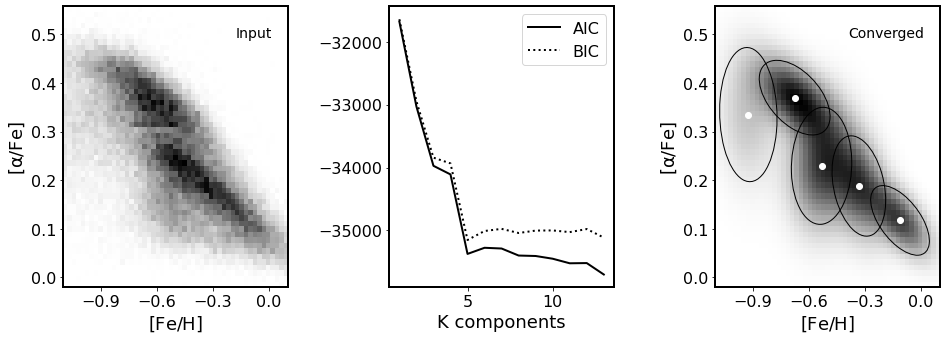

In [6]:
# https://www.astroml.org/book_figures/chapter6/fig_EM_metallicity.html
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.utils.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.

#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GaussianMixture models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('K components')
# plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

#### Choosing the number of models

There are two common tools to choose the number of modells to use in a Gaussian mixture, and both are based on hypothesis testing of two models with a different number of parameters. These are the Bayesian Information Criterion (BIC): 
$$
\mathrm{BIC} \equiv -2 \ln [L^0(K)] + k \ln N
$$
and the Akaike Information Criterion (AIC): 
$$
\mathrm{AIC} \equiv -2 \ln (L^0(K)] + 2k + \frac{2 k (k+1)}{N - k - 1}. 
$$
Both provide a way to quantify the amount of information in a model with $K$ parameters fit to $N$ data points, and both penalize models with more parameters. 

The left panel shows a Hess diagram of some data from the SDSS Segue survey. The middle column shows the values of AIC and BIC as a function of the number of components. Both information critera find the best match with five components. The panel on the right plots the five Gaussian models, which are also marked with ellipses. 

An important point to note is that a visual inspection of the left panel suggests two components, whereas the GMM preferred five. It is not uncommon for a GMM to identify more components, and two reasons this can occur are that the data are not well represented by Gaussians and there is some smooth background component. 

The right approach depends on the goal. In some cases it may be reasonable to limit the number of models to the apparent number of clusters in the data. In other cases, it may be reasonable to use many models. This may be the case if the goal is simply to approximate the pdf.

One common application of GMMs is to _clone_ the data, that is to find a good model representation for some distribution of point data, and then use that representation as a model of the underlying pdf. This is valuable if one wants to simulate a large dataset that is meant to be representative of a small, observed sample. 

